In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm import tqdm

try:
    import gym
except ImportError:
    %pip install gym
    import gym

# Import our classes
from random_agent import RandomAgent
from dqn_agent_base import DQNAgentBase
from dqn_agent_heuristic import DQNAgentHeuristic
from dqn_agent_rnd import DQNAgentRND
from dyna_agent import DynaAgent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Plotting settings and device
sns.set_theme(style='whitegrid')
color_palette = plt.cm.tab10.colors
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # else gives error when trying to plot

## Define Environment by Gymnasium

[Environment Details](https://gymnasium.farama.org/environments/classic_control/mountain_car/)

Full Example on Github of the [Mountain Car](https://github.com/guillaumefrd/q-learning-mountain-car)

In [3]:
env = gym.make('MountainCar-v0', render_mode='human')

In [4]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)


#### <span style="text-decoration:underline;">Explanations:</span>
- Observation space:
    - [-1.2 0.6] position range (in m)
    - [-0.07 0.07] velocity range (in v = m/s)
    - 2dim phase space (x-v-space)
- Actions:
    - 0: Accelerate to left
    - 1: Don't accelerate
    - 2: Accelerate to right
### <span style="text-decoration:underline;">Transition dynamics:</span>
<span style="text-decoration:underline;">Variables:</span>

Force $F$, action $a$, position $x$, velocity $v$, time (discrete) $t$, gravity $g$

The transition dynamics then reads:
$$
\begin{align}
v_{t+1} &= v_t + (a - 1)F - \cos(3x_t)g\\ 
x_{t+1} &= x_t + v_{t+1}
\end{align}
$$

Physical explanation:
- $ (a - 1) \implies$: -1: left, 0; no acceleration; +1: right acceleration; magnitude $F$
- Physically, the dimensions are an acceleration (setting $m=1$ and having a force balance of $\Delta v = v_{t+1}-v_t$)
- The last term is gravitational force, where the angle is expressed as $\alpha=3x$

#### <span style="text-decoration:underline;">Notes</span>
- The default reward setting is -1 per time step
- Environment acts stochastically, start position is in a fixed range

#### Define the general functions

### Plotting Functions

In [5]:
# Plotting functions

def plot_mean_reward_per_episode(reward_dict, window_size=25, ax=None):
    """
    reward_dict: dictionary containing the rewards per episode, optionally add environment and auxiliary rewards
    class_name: name of the class
    save_name: name to save the plot
    """
    if ax is None:
        _, ax = plt.subplots()
    for key in reward_dict:
        moving_avg = np.convolve(reward_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [reward_dict[key][i:i + window_size] for i in range(len(reward_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("episodes_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Cumulative rewards per episode')
    #if len(reward_dict) > 1:
    #    ax.legend()  # --> remove as it is plotted for cumulative reward already, looks better


def plot_cumulative_rewards(reward_dict, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for key in reward_dict:
        cum_rewards = np.cumsum(reward_dict[key])
        ax.plot(cum_rewards, label=f'{key}'.replace("episodes_", ""))
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Cumulative rewards up to episode n')
    if len(reward_dict) > 1:
        ax.legend()


def plot_training_loss(loss_dict, window_size=250, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    for key in loss_dict:
        moving_avg = np.convolve(loss_dict[key], np.ones(window_size) / window_size, mode='valid')
        moving_CI = np.std(
            [loss_dict[key][i:i + window_size] for i in range(len(loss_dict[key]) - window_size + 1)], axis=1) / np.sqrt(window_size) * 1.96

        ax.plot(moving_avg, label=f'{key}'.replace("training_", ""))
        ax.fill_between(np.arange(len(moving_avg)), moving_avg - moving_CI, moving_avg + moving_CI, alpha=0.2)
    ax.set_xlabel('Steps')
    ax.set_ylabel('MSE per step')
    if len(loss_dict) > 1:
        ax.legend() 


def plot_success(training_stats, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(training_stats['cumulative_successes'])
    ax.set_xlabel('Episode')
    ax.set_ylabel('Cumulative number of successes')

def plot_episode_duration(training_stats, ax=None):
    episodes = np.arange(len(training_stats['episodes_lengths']))
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(episodes, training_stats['episodes_lengths'], alpha=0.8, s=0.75)
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Steps taken')

# Create list of possible keys for rewards
reward_keys = ['episodes_rewards', 'episodes_environment_rewards', 'episodes_auxiliary_rewards']
loss_keys = ['steps_dqn_loss', 'steps_rnd_loss']

## Define a Run function to run the Agent 

In [41]:
def run(agent, episodes, render=False):
    """
    Run the Agent through the environment
    :param agent: the agent to run on the environment
    :param episodes: number of episodes to run the algorithm
    :param render: boolean to render the environment or not
    """

    # load the environment
    env = gym.make('MountainCar-v0', render_mode='human' if render else None)

    for _ in tqdm(range(episodes)):
        # reset episode and episode's statistics
        state, _ = env.reset()

        terminated = False
        truncated = False

        while not (terminated or truncated):
            # select and take action based on agent's policy
            action = agent.select_action(state)
            next_state, environment_reward, terminated, truncated, _ = env.step(action)

            # Observe transition
            agent.observe(state, action, next_state, environment_reward, terminated, truncated)

            # update state
            state = next_state   
        
    # Save the agent
    agent.save()

    env.close()

## Random Agent

#### Run the random agent for an episode and render it

In [9]:
random_agent = RandomAgent(env)
run(random_agent, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.22s/it]


#### Run the random Agent 100 times and plot the lengths of the episodes for different max lengths.

100%|██████████| 100/100 [00:00<00:00, 241.92it/s]


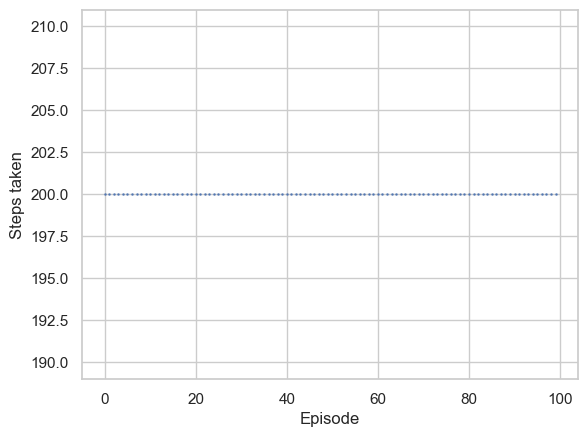

In [45]:
random_agent = RandomAgent(env)
run(random_agent, 100)
plot_episode_duration(random_agent.get_training_dict())

## DQN Agent without heuristic auxiliary reward

In [17]:
# Train the agent
dqn_agent_base = DQNAgentBase(env, trainable=True)
run(dqn_agent_base, 1000)

100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


In [38]:
# Render the agent
dqn_agent_render_normal = DQNAgentBase(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_normal, 1, render=True)

100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


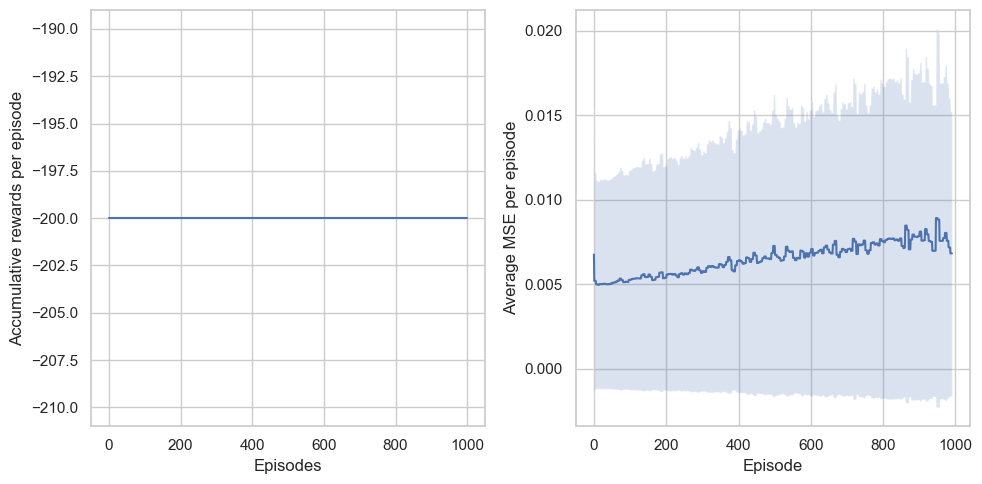

In [46]:
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

reward_dict = {'episodes_environment_rewards': dqn_agent_base.episodes_env_rewards}
loss_dict = {'steps_dqn_loss': dqn_agent_base.episodes_dqn_losses}

plot_mean_reward_per_episode(reward_dict, window_size=1, ax=ax1)
plot_training_loss(loss_dict, window_size=10, ax=ax2)

# Change the labels for this specific plot (asked about loss per episode I think)
ax2.set(xlabel='Episodes', ylabel='Average MSE per episode')

plt.tight_layout()

plt.savefig('figures/DQN_Agent_base.png')
plt.show()

- The Agent does not solve the problem
- As we never reach the goal and each step yields -1 reward, there is no learning in process as the Q-values will all be equal!

## Train an agent with DQN and a heuristically chosen auxiliary reward 
- The chosen reward function is based on the total energy of the system
$$\begin{align*}
E_{tot} 
&= mgz + \dfrac{m}{2}\dot{x}^2\\
&= mg\sin(x) + \dfrac{m}{2}v^2\\
&\propto \alpha \sin(x) + \beta \dot{x}^2
\end{align*}$$
- We rescale in the following manner:
    - $E_{tot}$ must not exceed 1 $\implies$ all possible states should give negative rewards, finding the goal quickly has to remain the primary objective, hence we have to punish each step
    - As there is no given sense of time scale, we rescale the velocity such that maximum velocity at lowest position yields the same reward as highest position at zero velocity (this ensures energy conservation). This should motivate the agent to add energy to the system by accelerating in the right moment
    - Hence the position and velocity terms are restricted to an upper limit of $0.5$ each


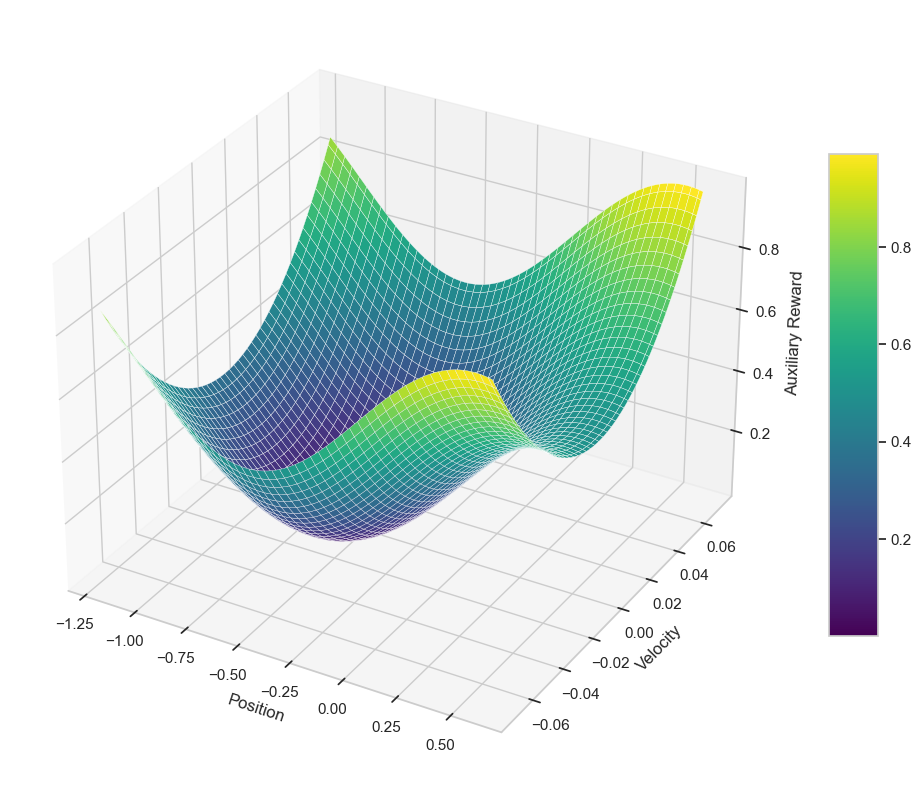

In [9]:
# Displaying the chosen reward function
x = np.linspace(-1.2, 0.6, 100)
y = np.linspace(-0.07, 0.07, 100)
X, Y = np.meshgrid(x, y)
Z = (np.sin(3 * X) + 1) / 4 + (Y*100/7) ** 2 / 2

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0.25, label='heuristic reward')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('Auxiliary Reward')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_function.png')
plt.show()

In [14]:
dqn_agent_heuristic = DQNAgentHeuristic(env, trainable=True)
run(dqn_agent_heuristic, 3000)

100%|██████████| 3000/3000 [17:08<00:00,  2.92it/s]


In [15]:
# Render
dqn_agent_render_heuristic = DQNAgentHeuristic(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_heuristic, 1, render=True)

100%|██████████| 1/1 [00:03<00:00,  3.99s/it]


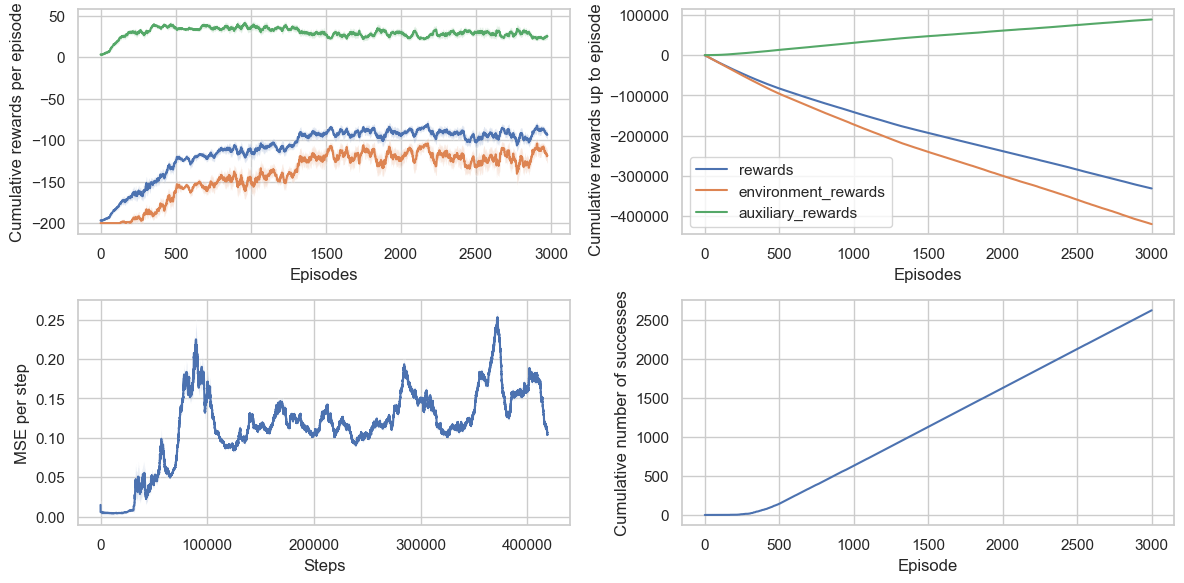

In [16]:
# plot results
heuristic_training_stats = dqn_agent_heuristic.get_training_dict()
heuristic_reward_dict = {key: heuristic_training_stats[key] for key in reward_keys}
heuristic_loss_dict = {'steps_dqn_loss': heuristic_training_stats['steps_dqn_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

plot_mean_reward_per_episode(heuristic_reward_dict, ax=ax[0][0])
plot_cumulative_rewards(heuristic_reward_dict, ax=ax[0][1])
plot_training_loss(heuristic_loss_dict, window_size=1000, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][1])

plt.tight_layout()
plt.savefig('figures/DQN_Agent_heuristic.png')
plt.show()

## Heuristic reward with different auxiliary reward scalings

In [11]:
reward_factors = [0, 0.05, 0.1, 0.5, 1, 2.5, 5]
aux_dicts = {}
for reward_factor in reward_factors:
    dqn_agent_aux = DQNAgentHeuristic(env, trainable=True, domain_reward_factor=reward_factor, epsilon_decay=0.99997)  # Changed decay for 1000 episodes
    run(dqn_agent_aux, 1000)
    aux_dicts[f'heuristic_training_{reward_factor}'] = dqn_agent_aux.get_training_dict()

100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


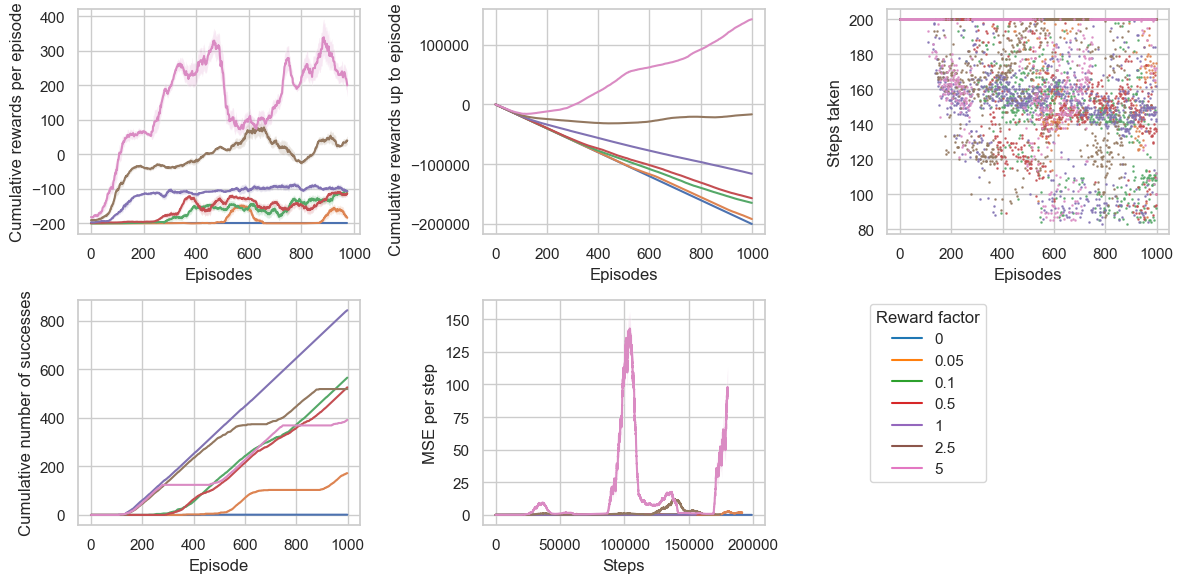

In [26]:
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, window_size=1000, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation.png')

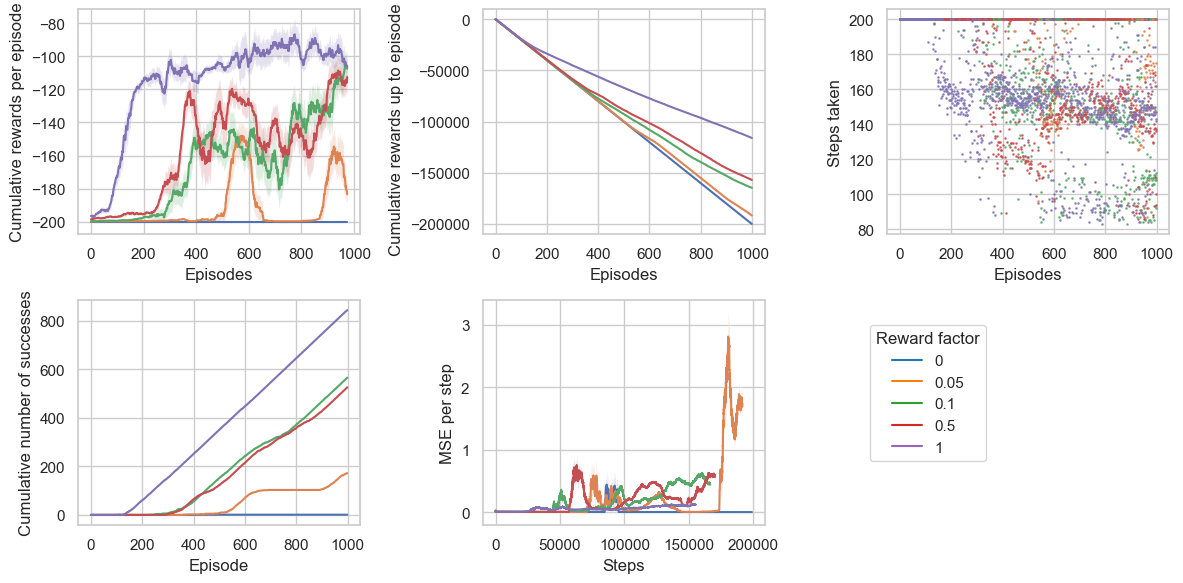

In [25]:
# repeat previous plots without the > 1 reward factors
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

legend_handles = []
for i, reward_factor in enumerate(reward_factors[0:5]):
    domain_reward_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in reward_keys[0:1]}
    domain_loss_dicts = {key: aux_dicts[f'heuristic_training_{reward_factor}'][key] for key in loss_keys[0:1]}
    plot_mean_reward_per_episode(domain_reward_dicts, ax=ax[0][0])
    plot_cumulative_rewards(domain_reward_dicts, ax=ax[0][1])
    plot_training_loss(domain_loss_dicts, window_size=1000, ax=ax[1][1])
    plot_success(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[1][0])
    plot_episode_duration(aux_dicts[f'heuristic_training_{reward_factor}'], ax=ax[0][2])
    legend_handles.append(plt.Line2D([0], [0], color=color_palette[i], label=f'{reward_factor}'))
fig.delaxes(ax[1][2])
legend = fig.legend(title='Reward factor', handles=legend_handles, loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/auxiliary_reward_variation_below1.png')

## Implementing Random Network Distillation (RND)

In [29]:
dqn_agent_RND = DQNAgentRND(env, trainable=True)
run(dqn_agent_RND, 3000)

100%|██████████| 3000/3000 [30:00<00:00,  1.67it/s]


In [30]:
# Render
dqn_agent_render_RND = DQNAgentRND(env, trainable=False, epsilon=0.0)
run(dqn_agent_render_RND, 1, render=True)

100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


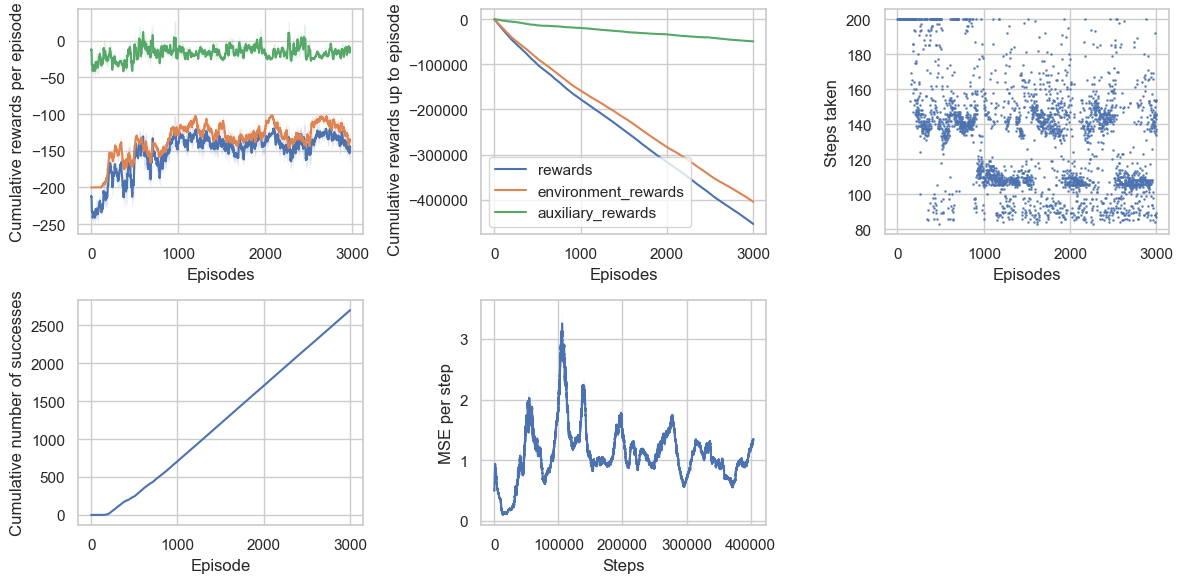

In [36]:
RND_training_stats = dqn_agent_RND.get_training_dict()

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

RND_rewards = {key: RND_training_stats[key] for key in reward_keys}
RND_losses = {'steps_dqn_loss': RND_training_stats['steps_dqn_loss']}
plot_mean_reward_per_episode(RND_rewards, ax=ax[0][0])
plot_cumulative_rewards(RND_rewards, ax=ax[0][1])
plot_training_loss(RND_losses, window_size=1000, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
#legend = fig.legend(title='Reward factor', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/DQNAgent_RND.png')

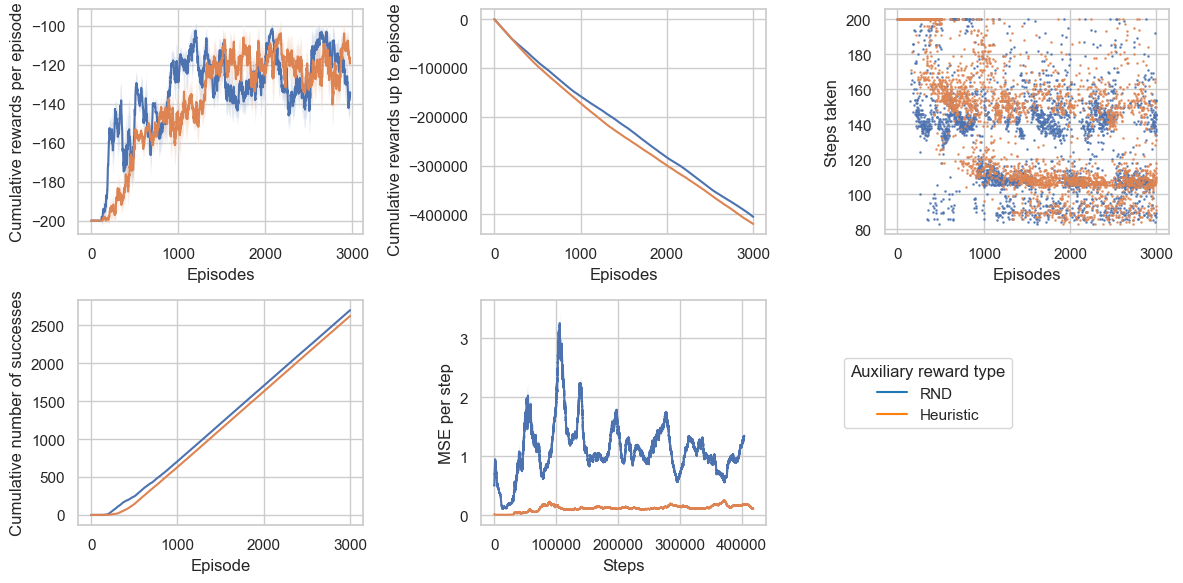

In [40]:
# compare RND to auxiliary
env_rewards_comp = {'episodes_environment_rewards RND': RND_training_stats['episodes_environment_rewards'],
                    'episodes_environment_rewards heuristic': heuristic_reward_dict['episodes_environment_rewards']}
losses_comp = {'steps_dqn_loss RND': RND_training_stats['steps_dqn_loss'],
               'steps_dqn_loss heuristic': heuristic_loss_dict['steps_dqn_loss']}

env_rewards_RND = {'episodes_environment_rewards': RND_training_stats['episodes_environment_rewards']}
env_rewards_heuristic = {'episodes_environment_rewards': heuristic_training_stats['episodes_environment_rewards']}
losses_RND = {'steps_dqn_loss': RND_training_stats['steps_dqn_loss']}
losses_heuristic = {'steps_dqn_loss': heuristic_training_stats['steps_dqn_loss']}

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)

ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

plot_mean_reward_per_episode(env_rewards_RND, ax=ax[0][0])
plot_mean_reward_per_episode(env_rewards_heuristic, ax=ax[0][0])
plot_cumulative_rewards(env_rewards_RND, ax=ax[0][1])
plot_cumulative_rewards(env_rewards_heuristic, ax=ax[0][1])
plot_training_loss(losses_RND, window_size=1000, ax=ax[1][1])
plot_training_loss(losses_heuristic, window_size=1000, ax=ax[1][1])
plot_success(RND_training_stats, ax=ax[1][0])
plot_success(heuristic_training_stats, ax=ax[1][0])
plot_episode_duration(RND_training_stats, ax=ax[0][2])
plot_episode_duration(heuristic_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
# create legend
legend_handles = [plt.Line2D([0], [0], color=color_palette[0], label='RND'),
                  plt.Line2D([0], [0], color=color_palette[1], label='Heuristic')]
legend = fig.legend(handles=legend_handles, title='Auxiliary reward type', loc='center', bbox_to_anchor=(0.78, 0.33))

plt.tight_layout()
plt.savefig('figures/RND_vs_auxiliary.png')
plt.show()

### DYNA Algorithm

In [66]:
# Train agent
dyna_agent = DynaAgent(env, trainable=True)
run(dyna_agent, 3000)

 11%|█         | 331/3000 [01:25<11:32,  3.85it/s]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "C:\Users\dgeno\miniconda3\envs\mnlp\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dgeno\AppData\Local\Temp\ipykernel_6952\3802054701.py", line 3, in <module>
    run(dyna_agent, 3000)
  File "C:\Users\dgeno\AppData\Local\Temp\ipykernel_6952\689619457.py", line 25, in run
    agent.observe(state, action, next_state, environment_reward, terminated, truncated)
  File "C:\Users\dgeno\Documents\ANNRL Project\Rolls-Royce-Peak-Plower\dyna_agent.py", line 77, in observe
    self.update()
  File "C:\Users\dgeno\Documents\ANNRL Project\Rolls-Royce-Peak-Plower\dyna_agent.py", line 130, in update
    random_idx = np.random.randint(low=0, high=len(encountered_states_actions), size=self.k)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception 

In [ ]:
# Render
dyna_agent_render = DynaAgent(env, trainable=False, epsilon=0.0)
run(dyna_agent_render, 1, render=True)

In [ ]:
# Plot as before
dyna_training_stats = dyna_agent.get_training_dict()

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 3, figure=fig)
ax = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)]

dyna_rewards = {'episodes_environment_rewards': dyna_training_stats['episodes_environment_rewards']}
dyna_loss = {'steps_dqn_loss': dyna_training_stats['steps_dqn_loss']}
plot_mean_reward_per_episode(dyna_rewards, ax=ax[0][0])
plot_cumulative_rewards(dyna_rewards, ax=ax[0][1])
plot_training_loss(dyna_loss, window_size=1000, ax=ax[1][1])
plot_success(dyna_training_stats, ax=ax[1][0])
plot_episode_duration(dyna_training_stats, ax=ax[0][2])
fig.delaxes(ax[1][2])
#legend = fig.legend(title='Reward factor', loc='center', bbox_to_anchor=(0.78, 0.33))

# Change the label, as it is not the loss for Dyna
ax[1][1].set(ylabel='Average Q-value update per step')

plt.tight_layout()

In [ ]:
#plt.savefig('figures/DynaAgent.png')

## Still to do

- Play with the size of the discretization steps. What happens if you use overly large bins? On
the other hand, why would we refrain from using too small bins? Give an intuitive explanation,
backed up by experimental results.
- When running the agent for a sufficiently large number of episodes, do you see a pattern in the
episode duration plot? Try to find an explanation for this pattern. 
(Maybe already done but could use non-trainable agent + epsilon = 0.0)
- In addition to the previous plots, create a new one illustrating the estimation of the Q-values
after learning. The x-axis represents the car’s position, and the y-axis its velocity. On a given
position and velocity (i.e state s), the plot should show max_a Q(s, a). Do not show values for
states that were never encountered What pattern do you see? Comment on the plot.
- On top of the plot showing Q-values, plot a curved line showing some episode trajectories.
Choose key episodes that show the progression of the agent at solving the task. Show each of
these trajectories in separate plots. Can you relate what you see to the patterns in the episode
duration plot? Explain.
- Bonus: Create plots showing the progression of learned Q-values throughout training. Create
separate plots showing max_a Q(s, a) (same as before) for snapshots of DynaAgent at different
points in training.
- Create a plot where you compare the training performance of each agent: plot the environment
rewards achieved by each of the three agents during training. Comment on the results. (DQN-Heuristic, 
DQN-RND, Dyna)
- Now compare their testing performance on 1000 new episodes, each one initialized with a randomly sampled seed as before: 
Set epsilon = 0 and run each of the trained agents on testing environments. 
Make sure you are comparing the agents on the same set of seeds. Plot their performance and comment.
